<h1 style="padding-top: 25px;padding-bottom: 25px;text-align: left; padding-left: 10px; background-color: #DDDDDD; 
    color: black;"> <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> AC295: Advanced Practical Data Science </h1>

## Transfer Learning for Text & Word Embeddings

**Harvard University, Fall 2020**  
**Instructors**: Pavlos Protopapas  

---

**Each assignment is graded out of 5 points.  The topic for this assignment is Transfer Learning for Text.**

**Due:** 10/27/2020 10:15 AM EDT

**Submit:** We won't be re running your notebooks, please ensure output is visible in the notebook.

#### Learning Objectives

In this exercise you will cover the following topics:  
- Tokenizing text using Text Vectorization
- Perform text classification & create word emedddings
- Load pre-trained word embeddings and perform text classification
- Understand Word Embeddings

---

#### Imports

In [1]:
import os
import requests
import zipfile
import tarfile
import shutil
import json
import time
import sys
import string
import re
import numpy as np
import pandas as pd
from glob import glob
from string import Template
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.python.ops import io_ops
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
K.clear_session()


#### Verify Setup

In [2]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, 
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tensorflow version 2.3.0
keras version 2.4.0
Eager Execution Enabled: True
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#### Utils

In [3]:
def download_file(packet_url, base_path="", extract=False):
  if base_path != "":
    if not os.path.exists(base_path):
      os.mkdir(base_path)
  packet_file = os.path.basename(packet_url)
  with requests.get(packet_url, stream=True) as r:
      r.raise_for_status()
      with open(os.path.join(base_path,packet_file), 'wb') as f:
          for chunk in r.iter_content(chunk_size=8192):
              f.write(chunk)
  
  if extract:
    if packet_file.endswith(".zip"):
      with zipfile.ZipFile(os.path.join(base_path,packet_file)) as zfile:
        zfile.extractall(base_path)
    
    if packet_file.endswith(".tar.gz"):
      packet_name = packet_file.split('.')[0]
      with tarfile.open(os.path.join(base_path,packet_file)) as tfile:
        tfile.extractall(base_path)

def evaluate_model(model,test_data, training_results):
    
  # Get the model train history
  model_train_history = training_results.history
  # Get the number of epochs the training was run for
  num_epochs = len(model_train_history["loss"])

  # Plot training results
  fig = plt.figure(figsize=(15,5))
  axs = fig.add_subplot(1,2,1)
  axs.set_title('Loss')
  # Plot all metrics
  for metric in ["loss","val_loss"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()
  
  axs = fig.add_subplot(1,2,2)
  axs.set_title('Accuracy')
  # Plot all metrics
  for metric in ["accuracy","val_accuracy"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  plt.show()
  
  # Evaluate on test data
  evaluation_results = model.evaluate(test_data)
  print("Evaluation Results:", evaluation_results)

## Dataset

#### Download

In [4]:
start_time = time.time()
download_file("https://storage.googleapis.com/dataset_store/ac295/news300.zip", base_path="datasets", extract=True)
download_file("https://github.com/shivasj/dataset-store/releases/download/v3.0/glove.6B.100d.txt.zip", base_path="embedding", extract=True)
execution_time = (time.time() - start_time)/60.0
print("Download execution time (mins)",execution_time)

Download execution time (mins) 0.07883406082789103


#### Explore

In [5]:
data_dir = os.path.join("datasets","news300")
label_names = os.listdir(data_dir)

# Number of unique labels
num_classes = len(label_names) 
# Create label index for easy lookup
label2index = dict((name, index) for index, name in enumerate(label_names))
index2label = dict((index, name) for index, name in enumerate(label_names))

print("Number of classes:", num_classes)
print("Labels:", label_names)

# Generate a list of labels and path to text
data_x = []
data_y = []

for label in label_names:
  text_files = os.listdir(os.path.join(data_dir,label))
  data_x.extend([os.path.join(data_dir,label,f) for f in text_files])
  data_y.extend([label for f in text_files])

# Preview
print("data_x count:",len(data_x))
print("data_y count:",len(data_y))
print(data_x[:5])
print(data_y[:5])

# sns.countplot()
# plt.show()
np.unique(data_y, return_counts=True)

Number of classes: 3
Labels: ['politics', 'health', 'entertainment']
data_x count: 920
data_y count: 920
['datasets/news300/politics/182.txt', 'datasets/news300/politics/96.txt', 'datasets/news300/politics/132.txt', 'datasets/news300/politics/19.txt', 'datasets/news300/politics/68.txt']
['politics', 'politics', 'politics', 'politics', 'politics']


(array(['entertainment', 'health', 'politics'], dtype='<U13'),
 array([310, 310, 300]))

#### View Text

In [6]:
# Generate a random sample of index
data_samples = np.random.randint(0,high=len(data_x)-1, size=10)
for i,data_idx in enumerate(data_samples):
  # Read text
  txt = io_ops.read_file(data_x[data_idx])

  print("Label:",data_y[data_idx],", Text:",txt.numpy())

Label: politics , Text: b'Kayleigh McEnany just made things worse  (CNN)In the wake of President Donald Trump equivocating as to whether he would transfer power to Joe Biden in the event of a defeat at the ballot box in 40 days, White House press secretary Kayleigh McEnany tried to clear things up on Thursday. Spoiler alert: She didn\'t! "The President will accept the results of a free and fair election," said McEnany. Which, well, that ain\'t it. See, Trump has said -- as recently as Wednesday night-- that the only way the election will be fair is if we "get rid of the ballots and you\'ll have a very trans- -- we\'ll have a very peaceful -- there won\'t be a transfer, frankly; there\'ll be a continuation." So, by that standard, the only way that the election will be "free and fair" (in McEnany\'s words) is if all mail-in ballots -- many of which have already been sent and returned! -- are somehow disqualified (or something?). Which, because every poll suggests that Democratic voters a

#### Build Data Pipelines

##### Text Vectorization

[Reference](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization)

Generate Text Vector:
- Standardize each sample (usually lowercasing + punctuation stripping)
- Split each sample into substrings (usually words)
- Recombine substrings into tokens (usually ngrams)
- Index tokens (associate a unique int value with each token)
- Transform each sample using this index, either into a vector of ints or a dense float vector

In [7]:
# Text Vectorization
def standardize_text(input_text):
  # Convert to lowercase
  lowercase = tf.strings.lower(input_text)
  # Remove HTML tags
  stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
  return tf.strings.regex_replace(
      stripped_html, "[%s]" % re.escape(string.punctuation), ""
  )

# Load Text
def load_text(path, label=None):
  text = io_ops.read_file(path)
  if label is None:
    return text
  else:
    return text, label

# Feature constraints
max_features = 15000
sequence_length = 1000

# Initialize Text Vectorizer
text_vectorizer = TextVectorization(
    standardize=standardize_text,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

# Create the vocabulary of entire dataset
text_data = tf.data.Dataset.from_tensor_slices(data_x)
text_data = text_data.map(load_text, num_parallel_calls=AUTOTUNE)

# Generate Text Vector
start_time = time.time()
text_vectorizer.adapt(text_data.batch(64))
execution_time = (time.time() - start_time)/60.0
print("Execution time (mins)",execution_time)

# Get Vocabulary
vocabulary = text_vectorizer.get_vocabulary()
vocabulary_size = len(vocabulary)
print("Vocabulary Size:",vocabulary_size)
# Generate word index
word_index = dict(zip(vocabulary, range(vocabulary_size)))

Execution time (mins) 0.010191897551218668
Vocabulary Size: 15000


In [8]:
# Check Vocabulary : 0 is reserved for padding and index 1 is reserved for "out of vocabulary" tokens
print("Vocabulary:",vocabulary[:20])
print("Vocabulary Size:",len(vocabulary))

# Test our text vectorizer
test_text = txt = io_ops.read_file(data_x[data_samples[0]])
print(test_text)
test_text_vector = text_vectorizer([test_text.numpy()])
print("Shape:",test_text_vector.shape)
print(test_text_vector[0,:20])

Vocabulary: ['', '[UNK]', 'the', 'to', 'and', 'of', 'a', 'in', 'that', 'for', 'is', 'on', 'said', 'with', 'as', 'it', 'have', 'are', 'be', 'at']
Vocabulary Size: 15000
tf.Tensor(b'Kayleigh McEnany just made things worse  (CNN)In the wake of President Donald Trump equivocating as to whether he would transfer power to Joe Biden in the event of a defeat at the ballot box in 40 days, White House press secretary Kayleigh McEnany tried to clear things up on Thursday. Spoiler alert: She didn\'t! "The President will accept the results of a free and fair election," said McEnany. Which, well, that ain\'t it. See, Trump has said -- as recently as Wednesday night-- that the only way the election will be fair is if we "get rid of the ballots and you\'ll have a very trans- -- we\'ll have a very peaceful -- there won\'t be a transfer, frankly; there\'ll be a continuation." So, by that standard, the only way that the election will be "free and fair" (in McEnany\'s words) is if all mail-in ballots -- m

##### Split Data

In [9]:
validation_percent = 0.20

# Split data into train / validate
train_x, validate_x, train_y, validate_y = train_test_split(data_x, data_y, test_size=validation_percent)

print("train_x count:",len(train_x))
print("validate_x count:",len(validate_x))

train_x count: 736
validate_x count: 184


##### Create TF Dataset

In [10]:
batch_size = 64

# Convert all y labels to numbers
train_processed_y = [label2index[label] for label in train_y]
validate_processed_y = [label2index[label] for label in validate_y]

# Converts to y to binary class matrix (One-hot-encoded)
train_processed_y = to_categorical(train_processed_y, num_classes=num_classes, dtype='float32')
validate_processed_y = to_categorical(validate_processed_y, num_classes=num_classes, dtype='float32')

# Vectorize Text
def vectorize_text(text, label=None):
  text = tf.expand_dims(text, -1)
  text = text_vectorizer(text)
  if label is None:
    return text
  else:
    return text, label

# Create TF Dataset
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_processed_y))
validation_data = tf.data.Dataset.from_tensor_slices((validate_x, validate_processed_y))

#############
# Train data
#############
# Apply all data processing logic
train_data = train_data.map(load_text, num_parallel_calls=AUTOTUNE)
train_data = train_data.batch(batch_size)
train_data = train_data.map(vectorize_text, num_parallel_calls=AUTOTUNE)
train_data = train_data.cache().prefetch(buffer_size=100)

##################
# Validation data
##################
# Apply all data processing logic
validation_data = validation_data.map(load_text, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.batch(batch_size)
validation_data = validation_data.map(vectorize_text, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.cache().prefetch(buffer_size=100)

print("train_data",train_data)
print("validation_data",validation_data)

train_data <PrefetchDataset shapes: ((None, 1000), (None, 3)), types: (tf.int64, tf.float32)>
validation_data <PrefetchDataset shapes: ((None, 1000), (None, 3)), types: (tf.int64, tf.float32)>


## Questions:

**All data preparation steps have been performed and you can continue to building models in following questions**

Note on dataset input sizes:
```
# Feature constraints
max_features = 15000
sequence_length = 1000
```

In [11]:
# Taking which Semantic Segmentation with Transfer Learning Demo
def evaluate_model(model,test_data, training_results):
    
  # Get the model train history
  model_train_history = training_results.history
  # Get the number of epochs the training was run for
  num_epochs = len(model_train_history["loss"])

  # Plot training results
  fig = plt.figure(figsize=(15,5))
  axs = fig.add_subplot(1,2,1)
  axs.set_title('Loss')
  # Plot all metrics
  for metric in ["loss","val_loss"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()
  
  axs = fig.add_subplot(1,2,2)
  axs.set_title('Accuracy')
  # Plot all metrics
  for metric in ["accuracy","val_accuracy"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  plt.show()
  
  # Evaluate on test data
  evaluation_results = model.evaluate(test_data)
  print("Evaluation Results:", evaluation_results)

## Question 1 : Build a text classification model using FFNN (0.5 Point)

#### a) Build a Text Classification Model

- Build the model using a few `Dense` layers
- Input size is `1000`
- Do **NOT** use the `Embedding` layer in your model
- Use `categorical_crossentropy` loss
- Ensure there is a plot of your training history

In [12]:
model = Sequential()
model.add(layers.Dense(256, input_shape=(1000,), activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))


Epoch 1/50
12/12 [==============================] - 0s 22ms/step - loss: 847.2442 - accuracy: 0.4511 - val_loss: 477.1715 - val_accuracy: 0.4620
Epoch 2/50
12/12 [==============================] - 0s 5ms/step - loss: 136.2894 - accuracy: 0.7527 - val_loss: 417.3380 - val_accuracy: 0.4837
Epoch 3/50
12/12 [==============================] - 0s 5ms/step - loss: 140.8354 - accuracy: 0.7867 - val_loss: 697.5585 - val_accuracy: 0.4565
Epoch 4/50
12/12 [==============================] - 0s 5ms/step - loss: 48.8420 - accuracy: 0.9049 - val_loss: 312.5107 - val_accuracy: 0.5380
Epoch 5/50
12/12 [==============================] - 0s 5ms/step - loss: 8.6292 - accuracy: 0.9552 - val_loss: 305.1111 - val_accuracy: 0.5272
Epoch 6/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6073 - accuracy: 0.9864 - val_loss: 345.3806 - val_accuracy: 0.5435
Epoch 7/50
12/12 [==============================] - 0s 5ms/step - loss: 0.2250 - accuracy: 0.9932 - val_loss: 351.0025 - val_accuracy: 0.559

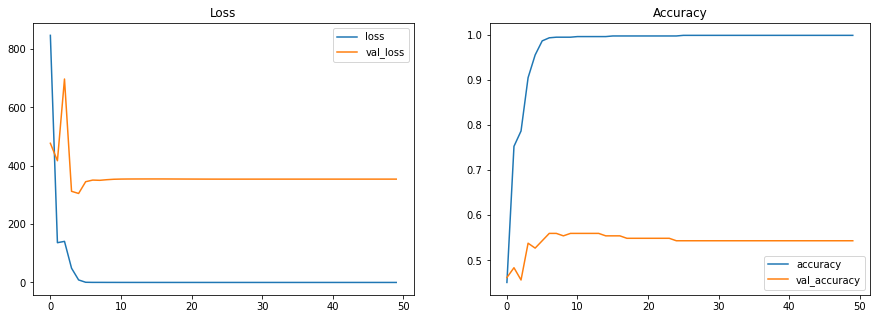

3/3 [==============================] - 0s 4ms/step - loss: 354.2904 - accuracy: 0.5435
Evaluation Results: [354.2904052734375, 0.54347825050354]


In [13]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=50,
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Evaluate model
evaluate_model(model,validation_data, training_results)

#### b) How is the performance of your model?

Honestly, bad. It looks like we're overfitting on the training data and not really learning much about sentences, as our validation accuracy is under 50%, which is marginally better than just picking a random class.



## Question 2 : Build a text classification model with embeddings (1.0 Point)

#### a) Preliminary Questions 

- Explain what is the purpose of the `Embedding` Layer ? 
- Name two reasons why using one-hot encoded vectors instead is not the way to go
- Explain what the inputs and outputs of the `Embedding` Layer are. Also comment on the dimension going in and what is coming out


The embeding layer creates vectors in a specified dimensional space that represent words. This is a huge improvement over one-hot encodings because such encodings have no notion of similarity between two words, so the words "cold", "cool", and "hot" are all equally similar, wheras by creating vectors for each word and learning them through our model we can establish a notion of similarity. 
The embedding layer takes the number of embeddings (number of words in your dataset) and the dimensional space of the embedding, and will then output these vectors. So in my case, with each sentence of length 1000 and a 16 dimensional space, my output wil lbe 1000x16

#### b) Build a Text Classification Model

- You need to include the `Embedding` layer in your model
- Following the `Embedding` layer you can use `Conv1D` or `LSTM`
- Use loss of `categorical_crossentropy`
- Ensure there is a plot of your training history



In [14]:
model = Sequential()
model.add(layers.Embedding(max_features,128,  input_shape=(1000,)))
model.add(layers.LSTM(200))
model.add(layers.Dense(3, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 128)         1920000   
_________________________________________________________________
lstm (LSTM)                  (None, 200)               263200    
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 603       
Total params: 2,183,803
Trainable params: 2,183,803
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
12/12 [==============================] - 2s 145ms/step - loss: 1.0741 - accuracy: 0.4484 - val_loss: 1.0396 - val_accuracy: 0.4946
Epoch 2/50
12/12 [==============================] - 1s 104ms/step - loss: 1.0299 - accuracy: 0.4878 - val_loss: 1.0337 - val_accuracy: 0.4946
Epoch 3/50
12/12 [==============================] - 1s 106ms/step - loss: 1.0030 - accuracy: 0.4864 - val_loss: 1.0166 - val_accuracy: 0.4946
Epoch 4/50
12/12 [==============================] - 1s 104ms/step - loss: 0.9602 - accuracy: 0.4891 - val_loss: 1.0351 - val_accuracy: 0.4946
Epoch 5/50
12/12 [==============================] - 1s 105ms/step - loss: 0.9078 - accuracy: 0.5149 - val_loss: 1.1430 - val_accuracy: 0.5163
Epoch 6/50
12/12 [==============================] - 1s 107ms/step - loss: 0.8756 - accuracy: 0.5747 - val_loss: 1.0013 - val_accuracy: 0.5272
Epoch 7/50
12/12 [==============================] - 1s 106ms/step - loss: 0.8688 - accuracy: 0.5707 - val_loss: 1.0030 - val_accuracy: 0.5109
Epoch 

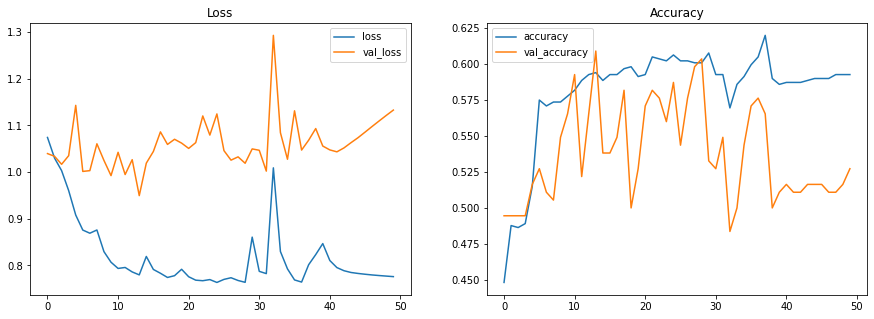

3/3 [==============================] - 0s 25ms/step - loss: 1.1328 - accuracy: 0.5272
Evaluation Results: [1.1328341960906982, 0.5271739363670349]


In [15]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=50,
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Evaluate model
evaluate_model(model,validation_data, training_results)

#### c) Save Embedding layer weights

- Save the weights of your embedding layer
- The weights will be used in Question 4
- Feel free to use the code below to extract layer weights

```
# Get the Embedding Layer
embedding_layer_no_tl = model.get_layer(name="embedding")
embedding_layer_no_tl_weights = embedding_layer_no_tl.get_weights()[0]
print(embedding_layer_no_tl_weights.shape)
```

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 128)         1920000   
_________________________________________________________________
lstm (LSTM)                  (None, 200)               263200    
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 603       
Total params: 2,183,803
Trainable params: 2,183,803
Non-trainable params: 0
_________________________________________________________________


In [18]:
embedding_layer_no_tl = model.get_layer(name="embedding")
embedding_layer_no_tl_weights = embedding_layer_no_tl.get_weights()[0]
print(embedding_layer_no_tl_weights.shape)


(15000, 128)



---

## Question 3 : Build a text classification model with pre-trained embeddings (2.5 Point)

#### a) Preliminary Questions 


- How is using pre-trained word embedding adding knowledge to the model? (Use an example if needed) 

- Provide a scenario where retraining the pre-trained embedding layer may be needed

In my above model, i'm relying on the backpropogation of my classification to learn the embeddings of each word. That's a pretty difficult task, especially considering all that we have to learn off is the classification of each sentence. However, there is a certain element of situaltional context in which these embeddings would need to be retrained. For instance if you had vectors that were trained on academic papers, but you then wanted to analyze facebook post data. Inevitably there would be new things to glean from the words on facebook that would have not been discovered in papers.


#### b) Build a Text Classifcation Model using pre-trained word embeddings

- Build a Text Classification Model
- You need to include the `Embedding` layer in your model
- The `Embedding` layer should have its weights loaded from any **pre-trained word embeddings** such as Glove, Word2Vec, FastText etc.
- [Example](https://medium.com/@ppasumarthi_69210/word-embeddings-in-keras-be6bb3092831) of how to load pre-trained word embeddings for Word2Vec
- [Example](https://keras.io/examples/nlp/pretrained_word_embeddings/) of how to load pre-trained word embeddings for Glove
- [Example](https://www.kaggle.com/vsmolyakov/keras-cnn-with-fasttext-embeddings) of how to load pre-trained word embeddings for FastText
- Make the `Embedding` layer as `trainable=False`
- Following the `Embedding` layer you can use `Conv1D` or `LSTM`
- Use loss of `categorical_crossentropy`
- Ensure there is a plot of your training history

In [19]:
# # !wget http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
# !unzip glove.6B.zip
# # 

In [20]:
# # load the whole embedding into memory
from tqdm.auto import tqdm
embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in f:
 values = line.split()
 word = values[0]
 coefs = np.asarray(values[1:], dtype='float32')
 embeddings_index[word] = coefs
f.close()
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((max_features, 100))
for word, i in tqdm(word_index.items()):
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector
np.save('embedding_matrix',embedding_matrix)

In [21]:
embedding_matrix.shape

(15000, 100)

In [22]:
model = Sequential()
model.add(layers.Embedding(max_features, 100, weights=[embedding_matrix], trainable=False))
model.add(layers.LSTM(200))
model.add(layers.Dense(3, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1500000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               240800    
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 603       
Total params: 1,741,403
Trainable params: 241,403
Non-trainable params: 1,500,000
_________________________________________________________________


Epoch 1/50
12/12 [==============================] - 1s 119ms/step - loss: 1.0352 - accuracy: 0.4701 - val_loss: 1.0163 - val_accuracy: 0.5217
Epoch 2/50
12/12 [==============================] - 1s 82ms/step - loss: 0.9526 - accuracy: 0.5217 - val_loss: 0.9620 - val_accuracy: 0.5815
Epoch 3/50
12/12 [==============================] - 1s 84ms/step - loss: 0.9330 - accuracy: 0.5272 - val_loss: 0.9672 - val_accuracy: 0.5815
Epoch 4/50
12/12 [==============================] - 1s 83ms/step - loss: 0.9011 - accuracy: 0.5448 - val_loss: 0.9041 - val_accuracy: 0.5870
Epoch 5/50
12/12 [==============================] - 1s 85ms/step - loss: 0.9930 - accuracy: 0.5014 - val_loss: 0.9830 - val_accuracy: 0.5435
Epoch 6/50
12/12 [==============================] - 1s 83ms/step - loss: 0.9630 - accuracy: 0.5027 - val_loss: 0.9901 - val_accuracy: 0.5109
Epoch 7/50
12/12 [==============================] - 1s 83ms/step - loss: 0.9200 - accuracy: 0.5258 - val_loss: 0.9311 - val_accuracy: 0.5815
Epoch 8/50
1

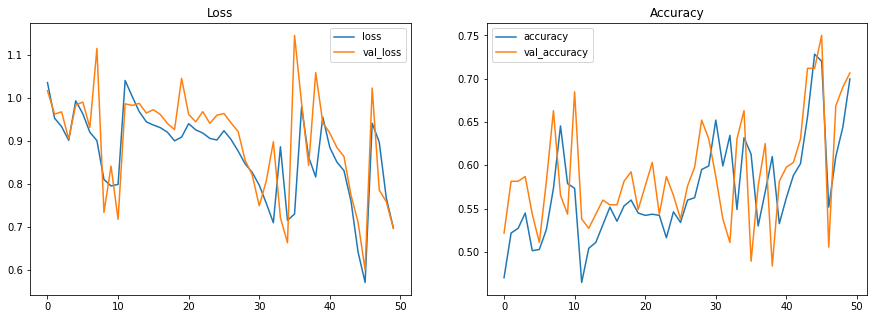

3/3 [==============================] - 0s 25ms/step - loss: 0.6966 - accuracy: 0.7065
Evaluation Results: [0.6966238617897034, 0.70652174949646]


In [23]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=50,
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Evaluate model
evaluate_model(model,validation_data, training_results)

#### c) Save Embedding layer weights

- Save the weights of your embedding layer
- The weights will be used in Question 4
- Feel free to use the code below to extract layer weights

```
# Get the Embedding Layer
embedding_layer_tl = model.get_layer(name="embedding")

embedding_layer_tl_weights = embedding_layer_tl.get_weights()[0]
print(embedding_layer_tl_weights.shape)
```

In [25]:
embedding_layer_tl = model.get_layer(name="embedding_1")
 
embedding_layer_tl_weights = embedding_layer_tl.get_weights()[0]
print(embedding_layer_tl_weights.shape)

(15000, 100)


---

## Question 4 : Analysing Word Embeddings (1.0 Point)

Feel free to use these functions for this question:

```
def find_similar(words, word_index, vocabulary, embedding_layer_weights, topn=5):
  subset_word_index  = []
  for word in words:
    subset_word_index.append(word_index[word])
  
  cs_op = cosine_similarity(embedding_layer_weights[subset_word_index], embedding_layer_weights)
  for idx in range(len(words)):
    top = cs_op[idx].argsort()[-topn:][::-1]
    for i,t in enumerate(top):
      if i ==0:
        print("Similar words for:",vocabulary[t])
      else:
        print("    ",vocabulary[t])

def find_analogy(word_a, word_b, word_c, word_index, vocabulary, embedding_layer_weights, topn=5):
  idx_a = word_index[word_a]
  idx_b = word_index[word_b]
  idx_c = word_index[word_c]

  # Vectors
  vec_a = embedding_layer_weights[idx_a]
  vec_b = embedding_layer_weights[idx_b]
  vec_c = embedding_layer_weights[idx_c]

  op = vec_b - vec_a + vec_c
  cs_op = cosine_similarity([op], embedding_layer_weights)
  top = cs_op[0].argsort()[-topn:][::-1]

  print(word_b,"-",word_a,"+", word_c, "=")
  for i,t in enumerate(top):
    print("   ",vocabulary[t])
```

In [66]:
def find_similar(words, word_index, vocabulary, embedding_layer_weights, topn=5):
  subset_word_index  = []
  for word in words:
    subset_word_index.append(word_index[word])
 
  cs_op = cosine_similarity(embedding_layer_weights[subset_word_index], embedding_layer_weights)
  for idx in range(len(words)):
    print("Similar words for:",words[idx])
    top = cs_op[idx].argsort()[-topn-1:][::-1]
    top_words = [vocabulary[word] for word in top]
    try:
      top_words.remove(str(words[idx]))
    except ValueError:
      pass
    top_words = top_words[:5]
    for i,t in enumerate(top_words):
        print("    ", t)
 
def find_analogy(word_a, word_b, word_c, word_index, vocabulary, embedding_layer_weights, topn=5):
  idx_a = word_index[word_a]
  idx_b = word_index[word_b]
  idx_c = word_index[word_c]
 
  # Vectors
  vec_a = embedding_layer_weights[idx_a]
  vec_b = embedding_layer_weights[idx_b]
  vec_c = embedding_layer_weights[idx_c]
 
  op = vec_b - vec_a + vec_c
  cs_op = cosine_similarity([op], embedding_layer_weights)
  top = cs_op[0].argsort()[-topn:][::-1]
 
  print(word_b,"-",word_a,"+", word_c, "=")
  for i,t in enumerate(top):
    print("   ",vocabulary[t])

#### a) Finding Semantically similar words

- We want to find words that are semantically similar to the following words: ```['covid19','election','2020','pandemic','quarantine']```
- Run the function `find_similar(...)` and display the results for embedding weights from question 2 and question 3

In [67]:
words = ['covid19','election','2020','pandemic','quarantine']

In [68]:
embedding_layer_no_tl
find_similar(words, word_index, vocabulary, embedding_layer_no_tl_weights, topn=5)


Similar words for: covid19
     contact
     starting
     new
     from
     youre
Similar words for: election
     however
     statement
     giants
     mention
     late
Similar words for: 2020
     seeing
     available
     situations
     pandemic
     kinds
Similar words for: pandemic
     anxiety
     help
     successful
     tests
     lacerda
Similar words for: quarantine
     therapists
     passantino
     asthma
     bonifield
     opinions


In [69]:

find_similar(words, word_index, vocabulary, embedding_layer_tl_weights, topn=5)


Similar words for: covid19
     oldest
     steroid
     skeptical
     slowed
     solely
Similar words for: election
     elections
     vote
     polls
     electoral
     presidential
Similar words for: 2020
     2015
     2050
     2030
     2017
     emissions
Similar words for: pandemic
     influenza
     flu
     epidemic
     h1n1
     virus
Similar words for: quarantine
     inspection
     quarantined
     sars
     poultry
     precaution


- Explain your results, does the similar words have any real world similarity?
- Explain the results of the word `covid19` from learned embeddings weights vs pre-trained embeddings weights

I would say that generally both models performed pretty well. Given covid19 was not in the Glove embeddings word list, it makes sense that the results are pretty nonsensical. Whereas it seems that covid19 was in the training data, and hence the learned vectors do much better. I suppose this demonstrates how often it is important to retrain embeddings when using current text sources, as new words and phrases emerge and without some training we can't really do much to figure it out.

#### b) Finding Analogies

- Word embeddings can be used to find analogies between words. For example, “man” is to “woman” as “son” is to “daughter” is an example of analogy, 
- Let us verify the `male-female` analogy
- Run the function `find_analogy(...)` and display the results for embedding weights from question 2 and question 3

In [71]:
#find_analogy('man', 'woman', 'son',...) for learned embeddings weights
find_analogy('man', 'woman', 'son', word_index, vocabulary, embedding_layer_no_tl_weights, topn=5)

woman - man + son =
    woman
    candidates
    president
    presidency
    issue


In [72]:
find_analogy('man', 'woman', 'son', word_index, vocabulary, embedding_layer_tl_weights, topn=5)

woman - man + son =
    daughter
    son
    wife
    mother
    father


- Explain your results, does word analogies work in both cases?

In this case, it seems that the training set responsible for my vectors is generally political coverage, and thus our representations of the worlds man woman and son are all pretty bad. Again, this i a testiment to the use of existing embeddings, as words that are unusual will hardly be learned without a huge dataset. Meanwhile, the glove embeddings do a really good job with the analogy, which makes sense as it was created with a much larger training set.

It's important to know the context of the questions you're trying to ask. Only if they're hyper-specific to your personal data does it really make sense to have your own embeddings created from scratch.